# Natural Language Processing with Disaster Tweets

In [1]:
import numpy as np
import pandas as pd 
import os

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score , confusion_matrix , classification_report

!pip install forge wordcloud
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
test_df=pd.read_csv("test.csv")
train_df=pd.read_csv("train.csv")
submission =pd.read_csv(r"submission.csv")

### Quick EDA

In [4]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
train_df['keyword'].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

In [7]:
train_df['location'].unique()

array([nan, 'Birmingham', 'Est. September 2012 - Bristol', ...,
       'Vancouver, Canada', 'London ', 'Lincoln'], dtype=object)

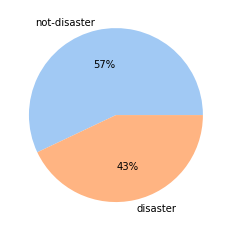

In [8]:
data = [train_df.groupby(['target']).count()['id'][0], train_df.groupby(['target']).count()['id'][1]]
colors = sns.color_palette('pastel')
labels = ['not-disaster', 'disaster']
plt.pie(data, colors = colors,labels=labels,autopct = '%0.0f%%')
plt.show()

Text(0.5, 0, 'A particular keywords from the disaster tweet (may be blank)')

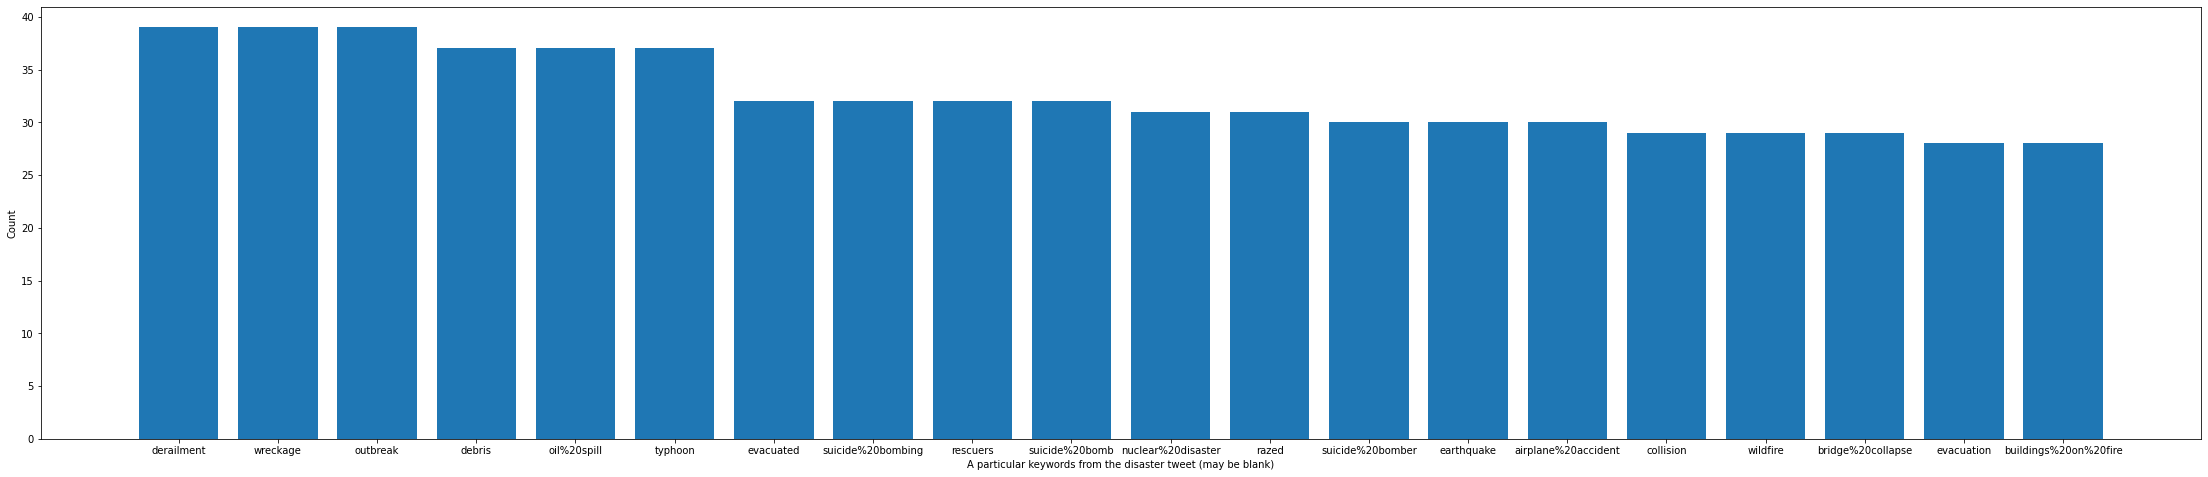

In [9]:
palette=sns.color_palette('magma')
data=pd.DataFrame((train_df[train_df['target']==1]).groupby(['keyword']).count().id.sort_values(ascending=False)[:20]).reset_index()
fig=plt.figure(figsize=(30,6))
ax = fig.add_axes([0,0,1,1])
ax.bar(data.keyword,data.id)
ax.set_ylabel('Count')
ax.set_xlabel('A particular keywords from the disaster tweet (may be blank)')

Text(0.5, 0, 'A particular keywords from the not-disaster tweet (may be blank)')

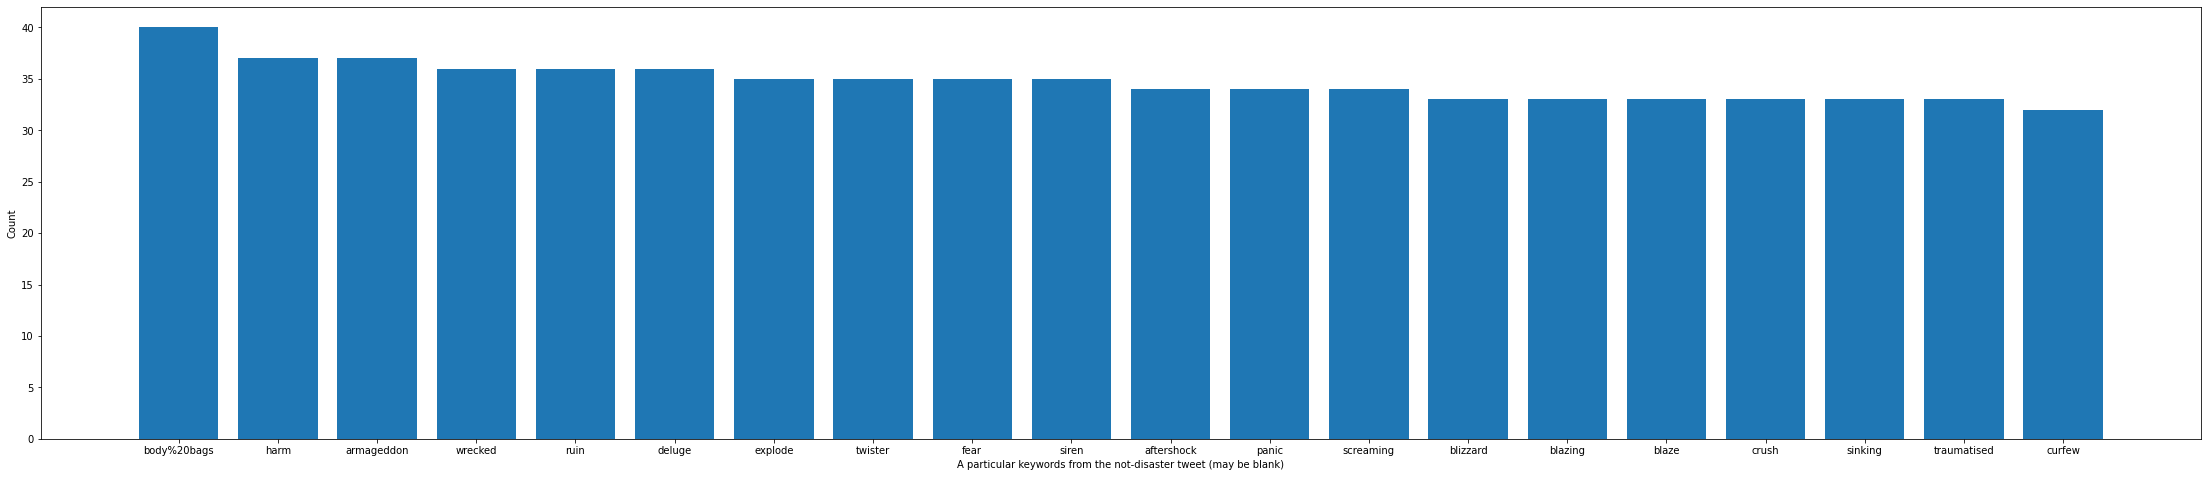

In [10]:
data=pd.DataFrame((train_df[train_df['target']==0]).groupby(['keyword']).count().id.sort_values(ascending=False)[:20]).reset_index()
fig=plt.figure(figsize=(30,6))
ax = fig.add_axes([0,0,1,1])
ax.bar(data.keyword,data.id)
ax.set_ylabel('Count')
ax.set_xlabel('A particular keywords from the not-disaster tweet (may be blank)')

Text(0.5, 0, 'The location the tweet was sent from (may also be blank)')

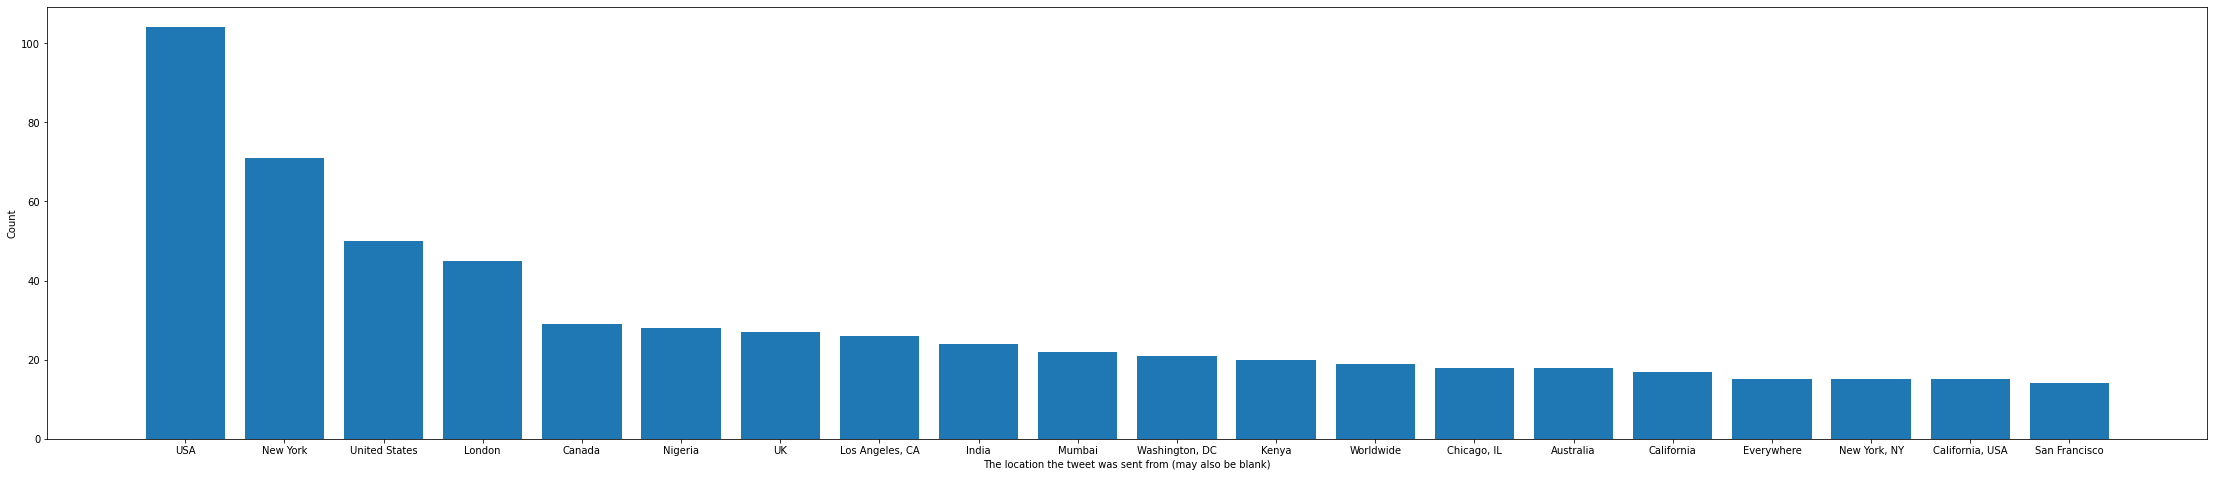

In [11]:
data=pd.DataFrame(train_df.groupby('location').count().id.sort_values(ascending=False)[:20]).reset_index()
fig=plt.figure(figsize=(30,6))
ax = fig.add_axes([0,0,1,1])
ax.bar(data.location,data.id)
ax.set_ylabel('Count')
ax.set_xlabel('The location the tweet was sent from (may also be blank)')

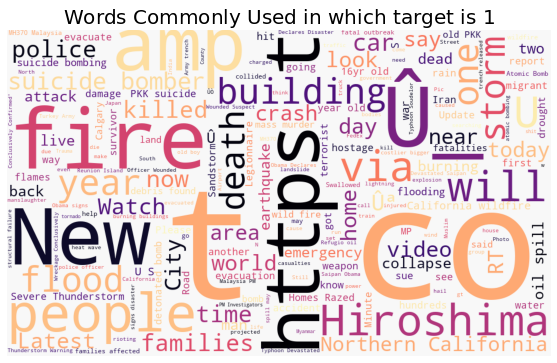

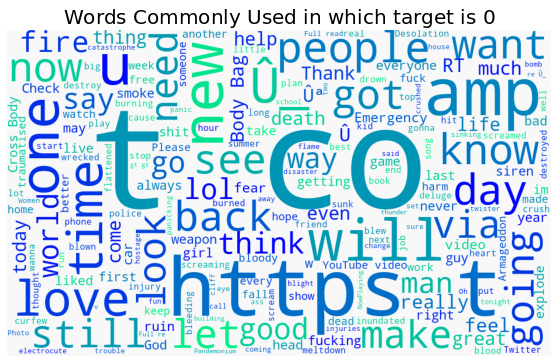

In [12]:
#WordCloud for the Sentiments
for label, cmap in zip([1,0],
                       ['magma','winter']):
    text = train_df.query('target == @label')['text'].str.cat(sep=' ')
    plt.figure(figsize=(10, 6))
    wc = WordCloud(width=1000, height=600, background_color="#f8f8f8", colormap=cmap)
    wc.generate_from_text(text)
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"Words Commonly Used in which target is ${label}$", size=20)
    plt.show()

### Data Pre-Processing

In [13]:
train_df.replace(regex={'%20': ' '},inplace=True)

Replacing chat messages to real message

In [14]:
train_df.replace(regex={'AFAIK':'As Far As I Know',
' AFK ':' Away From Keyboard ',
' ASAP ':' As Soon As Possible ',
' ATK ':' At The Keyboard ',
' ATM ':' At The Moment ',
' A3 ':' Anytime, Anywhere, Anyplace ',
' BAK ':' Back At Keyboard ',
' BBL ':' Be Back Later ',
' BBS ':' Be Back Soon ',
' BFN ':' Bye For Now ',
' B4N ':' Bye For Now ',
' BRB ':' Be Right Back ',
' BRT ':' Be Right There ',
' BTW ':' By The Way ',
' B4 ':' Before ',
' B4N ':' Bye For Now ',
' CU ':' See You ',
' CUL8R ':' See You Later ',
' CYA ':' See You ',
' FAQ ':' Frequently Asked Questions ',
' FC ':' Fingers Crossed ',
' FWIW ':" For What It's Worth ",
' FYI ':' For Your Information ',
' GAL ':' Get A Life ',
' GG ':' Good Game ',
' GN ':' Good Night ',
' GMTA ':' Great Minds Think Alike ',
' GR8 ':" Great! ",
' G9 ':" Genius ",
' IC ':" I See ",
' ICQ ':" I Seek you ",
' ILU ':" I Love You ",
' IMHO ':" In My Honest ",
' IMO ':" In My Opinion ",
' IOW ':" In Other Words ",
' IRL ':" In Real Life ",
' KISS ':" Keep It Simple, Stupid ",
' LDR ':" Long Distance Relationship ",
' LMAO ':" Laugh My Ass ",
' LOL ':" Laughing Out Loud ",
' LTNS ':" Long Time No See ",
' L8R ':" Later ",
' MTE ':" My Thoughts Exactly ",
' M8 ':" Mate ",
' NRN ':" No Reply Necessary ",
' OIC ':" Oh I See ",
' PITA ':" Pain In The Ass ",
' PRT ':" Party ",
' PRW ':" Parents Are Watching ",
' ROFL ':" Rolling On The Floor Laughing ",
' ROFLOL ':" Rolling On The Floor Laughing Out Loud ",
' ROTFLMAO ':" Rolling On The Floor Laughing My Ass ",
' SK8 ':" Skate ",
' STATS ':" Your sex and age ",
' ASL ':" Age, Sex, Location ",
' THX ':" Thank You ",
' TTFN ':" Ta-Ta For Now! ",
' TTYL ':" Talk To You Later ",
' U ':" You ",
' U2 ':" You Too",
' U4E ':" Yours For Ever ",
' WB ':" Welcome Back ",
' WTF ':" What The Fuck ",
' WTG ':" Way To Go! ",
' WUF ':" Where Are You From? ",
' W8 ':" Wait... ",},inplace=True)

In [15]:
train_df.replace(regex={r'https?://\S+': ' ',r'<.*?>':' ',r'\d+':' ',r'#\w+':' ','[^a-zA-Z]': ' ',r'http\S+': ' '},inplace=True)

### removing stop words

In [16]:
sw=stopwords.words('english')
train_df['text'][2]
train_df['text'] = train_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (sw)]))

In [17]:
train_df['text'][2]

'All residents asked shelter place notified officers No evacuation shelter place orders expected'

In [18]:
x = train_df["text"].to_numpy()
y = train_df["target"].to_numpy()

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

### Text Normalization Using TfidfVectorizer

In [20]:
def clean_text(text):
    punctuation = '''0123456789!()-[]:;"\,<>./?@#$%^_~*&{}'''
    nopunc = [char for char in text if char not in punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [21]:
# Creating TfidfVectorizer
vectorizer = TfidfVectorizer(use_idf=True, analyzer=clean_text, ngram_range=(1,3), min_df=1, stop_words='english')

x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)

test_texts = vectorizer.transform(test_df["text"])

### Model Training

In [22]:
model = MultinomialNB().fit(x_train, y_train)

In [23]:
y_pred = model.predict(x_test)

### Metrics

In [24]:
# finding accuracy_score
print("Accuracy Score is =",accuracy_score(y_test, y_pred))

Accuracy Score is = 0.7729658792650919


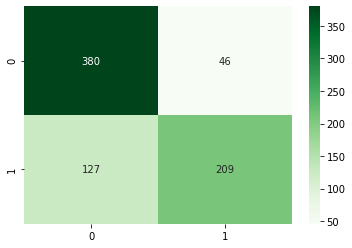

In [25]:
# calculating confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Greens', fmt='.3g')

In [26]:
# printing classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.89      0.81       426
           1       0.82      0.62      0.71       336

    accuracy                           0.77       762
   macro avg       0.78      0.76      0.76       762
weighted avg       0.78      0.77      0.77       762



### Submission

In [27]:
submission["target"] = model.predict(test_texts)
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [28]:
submission.to_csv('Submission.csv', index=False)

In [29]:
df = pd.read_csv('Submission.csv')

In [30]:
df.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [31]:
df.shape

(3263, 2)